In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

1.12.0


In [2]:
from configs.wavenet_biogas import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'biogas'), ('dilation_channels', 16), ('dilations', [1, 2, 4, 8, 16, 32, 64]), ('filter_width', 2), ('in_seq_len', 258), ('initial_filter_width', 2), ('input_channels', 1), ('input_dim', 1), ('lambd', 1e-10), ('learning_rate', 0.01), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.995), ('norm_epsilon', 1e-12), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('quantization_channels', 100), ('residual_channels', 16), ('sample_rate', 24), ('scalar_input', False), ('skip_channels', 32), ('test_split', 0.1), ('train_split', 0.8), ('use_biases', True), ('val_split', 0.1)]


In [19]:
hparams.num_layers  = 3
hparams.quantization_channels = 100
hparams.embd_pdrop  = 0.2
hparams.attn_pdrop  = 0.2
hparams.resid_pdrop = 0.2
hparams.num_states  = 64
hparams.num_heads   = 4
hparams.learning_rate = 1e-4
hparams.batch_size = 100
hparams.in_seq_len = 24
hparams.out_seq_len = 24 * 5
hparams.lambd=1e-6

In [4]:
from data_loader.sin import *
dataset, dataset_val, dataset_test = load_data(hparams, mode='fixed_frequency', normalise='random_scale_and_offset')
target, inp, mask, x_max = next(iter(dataset))

Added x, y data
Added y_mask data
Added x_max data


In [5]:
def jitter(inp, target):
    delta = tf.random.uniform((inp.shape[0],1,1), -0.05, 0.05)
    inp = inp + delta
    target = target + delta

    for _ in range(3):
        delta = tf.reduce_min(tf.minimum(tf.concat([inp, target], 1),0), axis=1, keepdims=True)
        inp = inp - 2 * delta
        target = target - 2 * delta

        delta = tf.reduce_max(tf.maximum(tf.concat([inp, target], 1) - 1,0), axis=1, keepdims=True)
        inp = inp - 2 * delta
        target = target - 2 * delta
        
    return inp, target

def create_gaussian_labels(inp):
    labels = tf.cast(hparams.quantization_channels * (inp), tf.int32)
    labels = tf.one_hot(labels, (hparams.quantization_channels+1))
    labels = tf.transpose(labels, [0,1,3,2])
    labels = gaussian_filter(labels)
    labels = tf.squeeze(labels)
    return labels

In [6]:
class GPT(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    '''
    def __init__(self, params, condition_model=False):
        super(GPT, self).__init__()

        self.num_layers            = params.num_layers
        self.quantization_channels = params.quantization_channels
        self.embd_pdrop            = params.embd_pdrop
        self.attn_pdrop            = params.attn_pdrop
        self.resid_pdrop           = params.resid_pdrop
        self.num_states            = params.num_states
        self.num_heads             = params.num_heads
        
        self.we = tf.get_variable('embedding', [self.quantization_channels + 1, self.num_states],
                                  initializer=tf.random_normal_initializer(stddev=0.02))
        #self.embed = tf.keras.layers.Embedding(self.quantization_channels + 1, self.num_states,
                                               #name='embedding')
            # Need an extra channel to create enough buckets e.g. [0-100] Needs 101 channels

        self.attn_layers = []
        self.norm_layers = []
        self.mlp_layers  = []
        for ix in range(self.num_layers):
            self._block(ix)

    ##########################################
    # Build functions
    ##########################################
    def _block(self, ix, scale=False):
        a = self._attn(ix, self.num_states, self.num_heads)
        self.attn_layers.append(a)

        g1 = tf.get_variable('g1_%i' % ix, [self.num_states], initializer=tf.constant_initializer(1))
        b1 = tf.get_variable('b1_%i' % ix, [self.num_states], initializer=tf.constant_initializer(0))
        g2 = tf.get_variable('g2_%i' % ix, [self.num_states], initializer=tf.constant_initializer(1))
        b2 = tf.get_variable('b2_%i' % ix, [self.num_states], initializer=tf.constant_initializer(0))
        self.norm_layers.append({'g1': g1, 'b1': b1, 'g2': g2, 'b2': b2})
        
        m_fc   = tf.keras.layers.Conv1D(self.num_states * 4, 1, name='mlp_fc_%i' % ix, activation='relu')
        m_proj = tf.keras.layers.Conv1D(self.num_states,     1, name='mlp_proj_%i' % ix)
        self.mlp_layers.append({'fc': m_fc, 'proj': m_proj})

        return

    def _attn(self, i, n_state, n_head):
        assert n_state%n_head==0
        layer = {}
        layer['conv']  = tf.keras.layers.Conv1D(n_state*3, kernel_size=1, padding='valid', name='conv_attn_%i' % i)
        layer['resid'] = tf.keras.layers.Conv1D(n_state,   kernel_size=1, padding='valid', name='proj_attn_%i' % i)
        return layer
            
    ##########################################
    # Call functions
    ##########################################
    def embed(self, x):
        e = tf.cast(self.quantization_channels * x, tf.int32)
        e = tf.gather(self.we, e)
        e = tf.reduce_sum(e, 2)
        return e
    
    def block(self, x, i, train=False, scale=False):
        a = self.attn(x, i, train=train)
        n = self.norm(x+a, g=self.norm_layers[i]['g1'], b=self.norm_layers[i]['b1'])
        m = self.mlp(n, i)
        h = self.norm(n+m, g=self.norm_layers[i]['g2'], b=self.norm_layers[i]['b2'])
        return h

    def attn(self, x, i, train=False):
        nm, nx, nf = x.shape.as_list() # Batch size, batch length, num filters
        nh = self.num_heads            # Num heads
        ns = nf // nh                  # Num split filters

        # Extract keys, queries and values
        c = self.attn_layers[i]['conv'](x)
        k, q, v = tf.split(c, 3, 2)
        k = tf.transpose(tf.reshape(k, [nm, nx, nh, ns]), [0, 2, 3, 1])
        q = tf.transpose(tf.reshape(q, [nm, nx, nh, ns]), [0, 2, 1, 3])
        v = tf.transpose(tf.reshape(v, [nm, nx, nh, ns]), [0, 2, 1, 3])
        
        # Attention Calculation
        w = tf.matmul(q, k)
                         
        # Mask Attention
        b = tf.matrix_band_part(tf.ones([nx, nx]), -1, 0)
        b = tf.reshape(b, [1, 1, nx, nx])
        w = w*b + -1e9*(1-b)

        # Apply Attention Weights
        w = tf.nn.softmax(w)
        if train: w = tf.nn.dropout(w, keep_prob=1-self.attn_pdrop)

        a = tf.matmul(w, v)
        a = tf.reshape(a, [nm, nx, nf])
        
        a = self.attn_layers[i]['resid'](a)
        if train: a = tf.nn.dropout(a, keep_prob=1-self.resid_pdrop)

        return a
    
    def norm(self, x, g=None, b=None, e=1e-5, axis=[1]):
        u = tf.reduce_mean(x, axis=axis, keep_dims=True)
        s = tf.reduce_mean(tf.square(x-u), axis=axis, keep_dims=True)
        x = (x - u) * tf.rsqrt(s + e)
        if g is not None and b is not None:
            x = x*g + b
        return x
    
    def mlp(self, x, i, train=False):
        x = self.mlp_layers[i]['fc'](x)
        x = self.mlp_layers[i]['proj'](x)
        if train: x = tf.nn.dropout(x, keep_prob=1-self.resid_pdrop)
        return x
            
    def call(self, inp, mask=None, train=False):
        
        assert(0 <= np.max(inp) <= 1.)
        inp = self.embed(inp)
        if train: inp = tf.nn.dropout(inp, keep_prob=1-self.embd_pdrop)

        for i in range(self.num_layers):
            inp = self.block(inp, i, train=train)
        
        nm, nx, nf = inp.shape.as_list()
        inp = tf.reshape(inp[:, :-1], [-1, self.num_states])
        inp = tf.matmul(inp, self.we, transpose_b=True)
        inp = tf.reshape(inp, [nm, nx-1, -1])
        
        return inp

In [14]:
model = GPT(hparams)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)
#optimizer = tf.train.RMSPropOptimizer(hparams.learning_rate)
if True:
    gaussian_filter = tf.keras.layers.Conv2D(1, kernel_size=(1,5), padding='same', use_bias=False,
                        kernel_initializer = tf.initializers.constant([[.01, .05, .88, .05, .01]]))
elif True:
    gaussian_filter = tf.keras.layers.Conv2D(1, kernel_size=(1,3), padding='same', use_bias=False,
                            kernel_initializer = tf.initializers.constant([[.01, .98, .01]]))

In [21]:
# Gaussian dilation embedded label
for epoch in range(50000):
    if epoch % 10 == 0:
        dataset, _, _ = load_data(hparams, mode='random_frequency', 
                                  normalise='random_scale_and_offset', isVerbose=False)
    losses = []
    for target, inp, mask, x_max in iter(dataset):
        with tf.GradientTape() as tape:
            pred = model(inp, train=True)

            labels=tf.cast(hparams.quantization_channels * inp[:, 1:, 0], tf.int32)
            ce_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=labels)
            ce_loss = tf.reduce_mean(ce_loss)
            
            l2_loss = tf.reduce_sum([tf.reduce_sum(var ** 2) * (1 if var.name.find('bias') == -1 else 0)\
                                     for var in model.trainable_variables]) * hparams.lambd
            
            loss = tf.reduce_sum([ce_loss, l2_loss])
            
        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)
    
    #optimizer._learning_rate *= 0.999
    if epoch % 10 == 0:
        print(epoch, ': ', np.round(np.dstack(losses).mean(), 3), np.round(ce_loss, 3), np.round(l2_loss,3))

0 :  2.032 2.03 0.002
10 :  2.189 2.187 0.002
20 :  2.183 2.181 0.002
30 :  2.131 2.129 0.002
40 :  2.118 2.116 0.002
50 :  2.145 2.144 0.002
60 :  2.138 2.136 0.002
70 :  2.1 2.098 0.002
80 :  2.08 2.078 0.002
90 :  2.315 2.313 0.002
100 :  2.102 2.1 0.002
110 :  2.064 2.062 0.002
120 :  2.068 2.066 0.002
130 :  2.109 2.107 0.002
140 :  2.109 2.107 0.002
150 :  2.191 2.189 0.002
160 :  2.04 2.039 0.002
170 :  2.218 2.216 0.002
180 :  2.179 2.177 0.002
190 :  2.099 2.097 0.002
200 :  2.07 2.069 0.002
210 :  2.113 2.111 0.002
220 :  2.134 2.132 0.002
230 :  2.198 2.196 0.002
240 :  2.075 2.073 0.002
250 :  2.144 2.143 0.002
260 :  2.163 2.161 0.002
270 :  2.154 2.152 0.002
280 :  2.171 2.169 0.002
290 :  2.157 2.155 0.002
300 :  2.113 2.111 0.002
310 :  2.092 2.09 0.002
320 :  2.044 2.043 0.002
330 :  2.166 2.164 0.002
340 :  2.138 2.136 0.002
350 :  2.152 2.15 0.002
360 :  2.071 2.069 0.002
370 :  2.201 2.199 0.002
380 :  2.106 2.104 0.002
390 :  2.167 2.165 0.002
400 :  2.147 2.145 0.

3230 :  2.055 2.053 0.002
3240 :  2.113 2.111 0.002
3250 :  2.192 2.19 0.002
3260 :  1.996 1.994 0.002
3270 :  2.056 2.054 0.002
3280 :  2.019 2.017 0.002
3290 :  2.137 2.135 0.002
3300 :  2.026 2.024 0.002
3310 :  2.081 2.079 0.002
3320 :  2.105 2.103 0.002
3330 :  2.069 2.067 0.002
3340 :  2.126 2.124 0.002
3350 :  2.05 2.048 0.002
3360 :  2.028 2.026 0.002
3370 :  2.145 2.143 0.002
3380 :  2.094 2.092 0.002
3390 :  2.002 2.0 0.002
3400 :  2.07 2.068 0.002
3410 :  1.938 1.936 0.002
3420 :  2.082 2.08 0.002
3430 :  2.188 2.186 0.002
3440 :  2.191 2.189 0.002
3450 :  2.168 2.166 0.002
3460 :  2.185 2.183 0.002
3470 :  2.068 2.066 0.002
3480 :  2.133 2.131 0.002
3490 :  2.089 2.088 0.002
3500 :  2.06 2.058 0.002
3510 :  2.129 2.127 0.002
3520 :  2.076 2.074 0.002
3530 :  2.024 2.022 0.002
3540 :  1.998 1.996 0.002
3550 :  2.095 2.093 0.002
3560 :  2.05 2.048 0.002
3570 :  2.255 2.253 0.002
3580 :  2.105 2.103 0.002
3590 :  2.145 2.143 0.002
3600 :  2.037 2.035 0.002
3610 :  2.012 2.01 0

6420 :  2.038 2.036 0.002
6430 :  1.974 1.972 0.002
6440 :  1.997 1.995 0.002
6450 :  2.082 2.08 0.002
6460 :  1.992 1.99 0.002
6470 :  2.061 2.059 0.002
6480 :  2.027 2.025 0.002
6490 :  2.101 2.099 0.002
6500 :  1.995 1.993 0.002
6510 :  2.023 2.021 0.002
6520 :  2.006 2.004 0.002
6530 :  2.067 2.065 0.002
6540 :  2.029 2.027 0.002
6550 :  2.033 2.031 0.002
6560 :  2.084 2.082 0.002
6570 :  2.093 2.091 0.002
6580 :  1.98 1.977 0.002
6590 :  1.976 1.974 0.002
6600 :  1.979 1.977 0.002
6610 :  1.996 1.994 0.002
6620 :  1.923 1.921 0.002
6630 :  2.003 2.001 0.002
6640 :  2.006 2.004 0.002
6650 :  2.068 2.066 0.002
6660 :  2.096 2.094 0.002
6670 :  2.034 2.032 0.002
6680 :  2.173 2.171 0.002
6690 :  1.991 1.989 0.002
6700 :  2.134 2.132 0.002
6710 :  1.985 1.983 0.002
6720 :  1.945 1.943 0.002
6730 :  2.062 2.06 0.002
6740 :  2.008 2.006 0.002
6750 :  2.173 2.171 0.002
6760 :  2.009 2.007 0.002
6770 :  2.075 2.073 0.002
6780 :  1.967 1.965 0.002
6790 :  1.994 1.992 0.002
6800 :  1.973 1.

9600 :  2.012 2.01 0.002
9610 :  2.089 2.087 0.002
9620 :  1.957 1.955 0.002
9630 :  2.089 2.087 0.002
9640 :  1.969 1.966 0.002
9650 :  2.035 2.033 0.002
9660 :  2.019 2.017 0.002
9670 :  1.918 1.916 0.002
9680 :  2.146 2.144 0.002
9690 :  1.97 1.968 0.002
9700 :  2.023 2.021 0.002
9710 :  1.997 1.995 0.002
9720 :  2.073 2.071 0.002
9730 :  1.919 1.917 0.002
9740 :  2.12 2.118 0.002
9750 :  1.978 1.976 0.002
9760 :  1.938 1.936 0.002
9770 :  1.984 1.982 0.002
9780 :  2.02 2.018 0.002
9790 :  1.989 1.987 0.002
9800 :  2.149 2.147 0.002
9810 :  2.001 1.999 0.002
9820 :  1.967 1.965 0.002
9830 :  1.959 1.957 0.002
9840 :  2.085 2.083 0.002
9850 :  1.989 1.987 0.002
9860 :  1.948 1.946 0.002
9870 :  2.033 2.031 0.002
9880 :  2.067 2.065 0.002
9890 :  2.036 2.034 0.002
9900 :  2.015 2.013 0.002
9910 :  1.943 1.941 0.002
9920 :  2.049 2.047 0.002
9930 :  1.988 1.986 0.002
9940 :  2.037 2.035 0.002
9950 :  2.015 2.013 0.002
9960 :  2.064 2.062 0.002
9970 :  2.018 2.016 0.002
9980 :  1.929 1.

12680 :  1.937 1.935 0.002
12690 :  1.994 1.992 0.002
12700 :  1.91 1.908 0.002
12710 :  1.961 1.958 0.002
12720 :  1.972 1.97 0.002
12730 :  2.07 2.068 0.002
12740 :  1.954 1.952 0.002
12750 :  1.957 1.955 0.002
12760 :  2.006 2.004 0.002
12770 :  1.949 1.946 0.002
12780 :  1.974 1.972 0.002
12790 :  1.963 1.961 0.002
12800 :  1.935 1.933 0.002
12810 :  1.984 1.981 0.002
12820 :  1.978 1.975 0.002
12830 :  1.985 1.983 0.002
12840 :  1.95 1.948 0.002
12850 :  1.967 1.964 0.002
12860 :  2.006 2.004 0.002
12870 :  2.056 2.053 0.002
12880 :  1.98 1.978 0.002
12890 :  2.002 1.999 0.002
12900 :  1.928 1.926 0.002
12910 :  2.092 2.09 0.002
12920 :  2.02 2.017 0.002
12930 :  1.975 1.973 0.002
12940 :  1.943 1.941 0.002
12950 :  2.031 2.029 0.002
12960 :  1.958 1.955 0.002
12970 :  1.948 1.946 0.002
12980 :  1.981 1.979 0.002
12990 :  1.998 1.996 0.002
13000 :  1.968 1.966 0.002
13010 :  2.085 2.083 0.002
13020 :  1.922 1.92 0.002
13030 :  2.024 2.022 0.002
13040 :  1.987 1.984 0.002
13050 :  

15750 :  1.96 1.957 0.002
15760 :  1.947 1.945 0.002
15770 :  1.95 1.948 0.002
15780 :  1.931 1.929 0.002
15790 :  1.902 1.9 0.002
15800 :  1.938 1.935 0.002
15810 :  1.867 1.865 0.002
15820 :  1.986 1.984 0.002
15830 :  1.954 1.951 0.002
15840 :  1.933 1.931 0.002
15850 :  2.013 2.011 0.002
15860 :  2.008 2.006 0.002
15870 :  1.929 1.927 0.002
15880 :  1.955 1.953 0.002
15890 :  1.993 1.991 0.002
15900 :  1.874 1.871 0.002
15910 :  1.993 1.991 0.002
15920 :  1.871 1.869 0.002
15930 :  1.914 1.912 0.002
15940 :  1.946 1.944 0.002
15950 :  1.902 1.9 0.002
15960 :  1.928 1.926 0.002
15970 :  2.007 2.005 0.002
15980 :  2.13 2.127 0.002
15990 :  1.986 1.984 0.002
16000 :  2.022 2.02 0.002
16010 :  1.877 1.875 0.002
16020 :  1.981 1.979 0.002
16030 :  1.937 1.935 0.002
16040 :  2.018 2.016 0.002
16050 :  1.849 1.847 0.002
16060 :  1.937 1.935 0.002
16070 :  1.875 1.873 0.002
16080 :  2.053 2.05 0.002
16090 :  1.911 1.909 0.002
16100 :  1.922 1.92 0.002
16110 :  1.942 1.94 0.002
16120 :  2.0

18820 :  1.935 1.933 0.002
18830 :  1.997 1.995 0.002
18840 :  1.841 1.838 0.002
18850 :  1.891 1.889 0.002
18860 :  1.962 1.96 0.002
18870 :  2.003 2.0 0.002
18880 :  1.904 1.901 0.002
18890 :  1.907 1.905 0.002
18900 :  1.951 1.948 0.002
18910 :  1.926 1.924 0.002
18920 :  1.841 1.838 0.002
18930 :  1.915 1.913 0.002
18940 :  1.936 1.934 0.002
18950 :  1.96 1.958 0.002
18960 :  1.923 1.921 0.002
18970 :  1.865 1.863 0.002
18980 :  1.887 1.884 0.002
18990 :  1.893 1.891 0.002
19000 :  1.819 1.817 0.002
19010 :  1.954 1.952 0.002
19020 :  1.94 1.938 0.002
19030 :  1.986 1.983 0.002
19040 :  1.916 1.914 0.002
19050 :  1.952 1.95 0.002
19060 :  2.031 2.028 0.002
19070 :  1.971 1.969 0.002
19080 :  1.856 1.853 0.002
19090 :  1.996 1.994 0.002
19100 :  2.056 2.054 0.002
19110 :  1.937 1.935 0.002
19120 :  2.1 2.098 0.002
19130 :  2.017 2.014 0.002
19140 :  1.955 1.953 0.002
19150 :  1.871 1.869 0.002
19160 :  1.866 1.863 0.002
19170 :  1.885 1.882 0.002
19180 :  1.974 1.972 0.002
19190 :  

21890 :  1.981 1.979 0.002
21900 :  1.881 1.879 0.002
21910 :  1.878 1.875 0.002
21920 :  1.966 1.964 0.002
21930 :  1.98 1.977 0.002
21940 :  1.994 1.992 0.002
21950 :  1.945 1.943 0.002
21960 :  1.881 1.878 0.002
21970 :  1.904 1.902 0.002
21980 :  1.92 1.917 0.002
21990 :  1.974 1.972 0.002
22000 :  1.928 1.926 0.002
22010 :  1.973 1.97 0.002
22020 :  1.933 1.93 0.002
22030 :  1.84 1.838 0.002
22040 :  1.825 1.823 0.002
22050 :  1.92 1.917 0.002
22060 :  1.903 1.901 0.002
22070 :  1.901 1.899 0.002
22080 :  1.801 1.799 0.002
22090 :  1.847 1.845 0.002
22100 :  1.981 1.978 0.002
22110 :  1.823 1.821 0.002
22120 :  1.861 1.859 0.002
22130 :  1.911 1.909 0.002
22140 :  1.862 1.86 0.002
22150 :  1.984 1.981 0.002
22160 :  1.93 1.928 0.002
22170 :  1.866 1.863 0.002
22180 :  1.912 1.909 0.002
22190 :  1.787 1.784 0.002
22200 :  1.951 1.949 0.002
22210 :  1.831 1.828 0.002
22220 :  1.997 1.994 0.002
22230 :  1.935 1.933 0.002
22240 :  1.889 1.886 0.002
22250 :  1.944 1.942 0.002
22260 :  

24950 :  1.949 1.947 0.002
24960 :  1.781 1.779 0.002
24970 :  1.903 1.901 0.002
24980 :  1.849 1.846 0.002
24990 :  1.937 1.935 0.002
25000 :  1.901 1.898 0.002
25010 :  1.86 1.858 0.002
25020 :  1.831 1.829 0.002
25030 :  1.846 1.844 0.002
25040 :  1.915 1.913 0.002
25050 :  1.921 1.919 0.002
25060 :  1.924 1.921 0.002
25070 :  1.854 1.852 0.002
25080 :  1.936 1.933 0.002
25090 :  1.91 1.907 0.002
25100 :  1.756 1.753 0.002
25110 :  1.957 1.954 0.002
25120 :  1.913 1.911 0.002
25130 :  1.952 1.95 0.002
25140 :  1.927 1.925 0.002
25150 :  1.92 1.918 0.002
25160 :  1.894 1.892 0.002
25170 :  1.927 1.924 0.002
25180 :  1.916 1.913 0.002
25190 :  1.863 1.861 0.002
25200 :  1.827 1.825 0.002
25210 :  1.733 1.731 0.002
25220 :  1.873 1.871 0.002
25230 :  1.852 1.849 0.002
25240 :  1.841 1.839 0.002
25250 :  1.962 1.96 0.002
25260 :  1.824 1.822 0.002
25270 :  1.806 1.804 0.002
25280 :  1.833 1.83 0.002
25290 :  1.956 1.954 0.002
25300 :  1.839 1.837 0.002
25310 :  1.794 1.791 0.002
25320 :

28010 :  1.779 1.777 0.002
28020 :  1.832 1.83 0.002
28030 :  1.947 1.945 0.002
28040 :  1.903 1.9 0.002
28050 :  1.904 1.902 0.002
28060 :  1.938 1.936 0.002
28070 :  1.839 1.836 0.002
28080 :  1.942 1.939 0.002
28090 :  1.835 1.832 0.002
28100 :  1.899 1.896 0.002
28110 :  1.835 1.833 0.002
28120 :  1.824 1.821 0.002
28130 :  1.821 1.819 0.002
28140 :  2.021 2.018 0.002
28150 :  1.914 1.912 0.002
28160 :  1.85 1.848 0.002
28170 :  1.842 1.84 0.002
28180 :  1.901 1.899 0.002
28190 :  1.871 1.869 0.002
28200 :  1.808 1.805 0.002
28210 :  1.854 1.852 0.002
28220 :  1.754 1.752 0.002
28230 :  1.819 1.817 0.002
28240 :  1.812 1.81 0.002
28250 :  1.867 1.865 0.002
28260 :  1.834 1.831 0.002
28270 :  1.871 1.869 0.002
28280 :  1.888 1.885 0.002
28290 :  1.815 1.812 0.002
28300 :  1.844 1.841 0.002
28310 :  1.868 1.866 0.002
28320 :  1.961 1.958 0.002
28330 :  1.902 1.9 0.002
28340 :  1.882 1.88 0.002
28350 :  1.975 1.972 0.002
28360 :  1.847 1.845 0.002
28370 :  1.837 1.835 0.002
28380 :  1

31610 :  1.821 1.819 0.003
31620 :  1.873 1.87 0.003
31630 :  1.83 1.828 0.003
31640 :  1.756 1.754 0.003
31650 :  1.881 1.879 0.003
31660 :  1.825 1.823 0.003
31670 :  1.849 1.846 0.003
31680 :  1.815 1.812 0.003
31690 :  1.878 1.876 0.003
31700 :  1.827 1.825 0.003
31710 :  1.963 1.961 0.003
31720 :  1.891 1.889 0.003
31730 :  1.851 1.848 0.003
31740 :  1.866 1.864 0.003
31750 :  1.827 1.824 0.003
31760 :  1.871 1.869 0.003
31770 :  1.933 1.93 0.003
31780 :  1.829 1.827 0.003
31790 :  1.872 1.869 0.003
31800 :  1.835 1.833 0.003
31810 :  1.886 1.883 0.003
31820 :  1.767 1.765 0.003
31830 :  1.863 1.86 0.003
31840 :  1.926 1.923 0.003
31850 :  1.938 1.936 0.003
31860 :  1.847 1.844 0.003
31870 :  1.95 1.947 0.003
31880 :  1.969 1.966 0.003
31890 :  1.843 1.841 0.003
31900 :  1.903 1.9 0.003
31910 :  1.896 1.894 0.003
31920 :  1.76 1.757 0.003
31930 :  1.893 1.891 0.003
31940 :  1.773 1.771 0.003
31950 :  1.788 1.785 0.003
31960 :  1.846 1.844 0.003
31970 :  1.814 1.812 0.003
31980 :  

34670 :  1.86 1.858 0.003
34680 :  1.783 1.781 0.003
34690 :  1.911 1.909 0.003
34700 :  1.926 1.924 0.003
34710 :  1.837 1.834 0.003
34720 :  1.894 1.892 0.003
34730 :  1.797 1.794 0.003
34740 :  1.806 1.804 0.003
34750 :  1.851 1.848 0.003
34760 :  1.804 1.801 0.003
34770 :  1.916 1.913 0.003
34780 :  1.904 1.902 0.003
34790 :  1.725 1.722 0.003
34800 :  1.866 1.864 0.003
34810 :  1.827 1.825 0.003
34820 :  1.912 1.91 0.003
34830 :  1.83 1.828 0.003
34840 :  1.843 1.841 0.003
34850 :  1.787 1.785 0.003
34860 :  1.821 1.818 0.003
34870 :  1.879 1.877 0.003
34880 :  1.929 1.926 0.003
34890 :  1.903 1.9 0.003
34900 :  1.843 1.841 0.003
34910 :  1.903 1.901 0.003
34920 :  1.8 1.798 0.003
34930 :  1.869 1.866 0.003
34940 :  1.769 1.766 0.003
34950 :  1.83 1.828 0.003
34960 :  1.818 1.816 0.003
34970 :  1.913 1.911 0.003
34980 :  1.881 1.878 0.003
34990 :  1.829 1.826 0.003
35000 :  1.868 1.865 0.003
35010 :  1.801 1.798 0.003
35020 :  1.88 1.877 0.003
35030 :  1.752 1.75 0.003
35040 :  1.

37730 :  1.765 1.762 0.003
37740 :  1.815 1.813 0.003
37750 :  1.782 1.779 0.003
37760 :  1.849 1.846 0.003
37770 :  1.754 1.751 0.003
37780 :  1.797 1.794 0.003
37790 :  1.803 1.801 0.003
37800 :  1.83 1.827 0.003
37810 :  1.774 1.771 0.003
37820 :  1.856 1.853 0.003
37830 :  1.832 1.83 0.003
37840 :  1.831 1.828 0.003
37850 :  1.798 1.796 0.003
37860 :  1.848 1.846 0.003
37870 :  1.806 1.803 0.003
37880 :  1.855 1.852 0.003
37890 :  1.937 1.934 0.003
37900 :  1.974 1.971 0.003
37910 :  1.762 1.76 0.003
37920 :  1.918 1.915 0.003
37930 :  1.828 1.825 0.003
37940 :  1.878 1.876 0.003
37950 :  1.845 1.842 0.003
37960 :  1.83 1.827 0.003
37970 :  1.835 1.832 0.003
37980 :  1.792 1.79 0.003
37990 :  1.791 1.789 0.003
38000 :  1.847 1.844 0.003
38010 :  1.89 1.887 0.003
38020 :  1.748 1.745 0.003
38030 :  1.888 1.885 0.003
38040 :  1.837 1.834 0.003
38050 :  1.887 1.884 0.003
38060 :  1.797 1.794 0.003
38070 :  1.79 1.787 0.003
38080 :  1.83 1.827 0.003
38090 :  1.8 1.797 0.003
38100 :  1.

40790 :  1.876 1.874 0.003
40800 :  1.861 1.858 0.003
40810 :  1.838 1.836 0.003
40820 :  1.785 1.782 0.003
40830 :  1.84 1.837 0.003
40840 :  1.758 1.756 0.003
40850 :  1.843 1.841 0.003
40860 :  1.873 1.871 0.003
40870 :  1.904 1.901 0.003
40880 :  1.81 1.807 0.003
40890 :  1.766 1.764 0.003
40900 :  1.843 1.84 0.003
40910 :  2.02 2.018 0.003
40920 :  1.888 1.885 0.003
40930 :  1.793 1.79 0.003
40940 :  1.857 1.855 0.003
40950 :  1.829 1.826 0.003
40960 :  1.849 1.847 0.003
40970 :  1.915 1.912 0.003
40980 :  1.874 1.871 0.003
40990 :  1.802 1.799 0.003
41000 :  1.819 1.816 0.003
41010 :  1.921 1.919 0.003
41020 :  1.775 1.773 0.003
41030 :  1.878 1.875 0.003
41040 :  1.952 1.949 0.003
41050 :  1.849 1.846 0.003
41060 :  1.787 1.784 0.003
41070 :  1.869 1.866 0.003
41080 :  1.777 1.775 0.003
41090 :  1.799 1.797 0.003
41100 :  1.806 1.803 0.003
41110 :  1.798 1.796 0.003
41120 :  1.768 1.766 0.003
41130 :  1.844 1.842 0.003
41140 :  1.752 1.749 0.003
41150 :  1.842 1.839 0.003
41160 

43850 :  1.812 1.81 0.003
43860 :  1.922 1.919 0.003
43870 :  1.842 1.84 0.003
43880 :  1.791 1.788 0.003
43890 :  1.827 1.824 0.003
43900 :  1.77 1.767 0.003
43910 :  1.758 1.756 0.003
43920 :  1.831 1.828 0.003
43930 :  1.869 1.866 0.003
43940 :  1.82 1.817 0.003
43950 :  1.731 1.729 0.003
43960 :  1.824 1.822 0.003
43970 :  1.784 1.782 0.003
43980 :  1.764 1.762 0.003
43990 :  1.843 1.84 0.003
44000 :  1.835 1.833 0.003
44010 :  1.871 1.869 0.003
44020 :  1.761 1.758 0.003
44030 :  1.778 1.775 0.003
44040 :  1.848 1.845 0.003
44050 :  1.796 1.794 0.003
44060 :  1.847 1.845 0.003
44070 :  1.744 1.741 0.003
44080 :  1.777 1.774 0.003
44090 :  1.794 1.792 0.003
44100 :  1.781 1.779 0.003
44110 :  1.777 1.775 0.003
44120 :  1.748 1.746 0.003
44130 :  1.829 1.826 0.003
44140 :  1.837 1.834 0.003
44150 :  1.885 1.882 0.003
44160 :  1.774 1.771 0.003
44170 :  1.858 1.855 0.003
44180 :  1.786 1.784 0.003
44190 :  1.807 1.805 0.003
44200 :  1.774 1.772 0.003
44210 :  1.805 1.802 0.003
44220 

46910 :  1.702 1.7 0.003
46920 :  1.748 1.745 0.003
46930 :  1.799 1.796 0.003
46940 :  1.811 1.809 0.003
46950 :  1.842 1.839 0.003
46960 :  1.834 1.831 0.003
46970 :  1.832 1.829 0.003
46980 :  1.806 1.803 0.003
46990 :  1.778 1.775 0.003
47000 :  1.759 1.757 0.003
47010 :  1.805 1.802 0.003
47020 :  1.748 1.745 0.003
47030 :  1.782 1.779 0.003
47040 :  1.901 1.898 0.003
47050 :  1.751 1.748 0.003
47060 :  1.814 1.811 0.003
47070 :  1.793 1.79 0.003
47080 :  1.854 1.851 0.003
47090 :  1.75 1.748 0.003
47100 :  1.761 1.758 0.003
47110 :  1.774 1.771 0.003
47120 :  1.752 1.749 0.003
47130 :  1.934 1.931 0.003
47140 :  1.706 1.703 0.003
47150 :  1.802 1.799 0.003
47160 :  1.729 1.726 0.003
47170 :  1.766 1.763 0.003
47180 :  1.779 1.776 0.003
47190 :  1.773 1.77 0.003
47200 :  1.784 1.781 0.003
47210 :  1.754 1.752 0.003
47220 :  1.743 1.741 0.003
47230 :  1.822 1.819 0.003
47240 :  1.784 1.782 0.003
47250 :  1.795 1.792 0.003
47260 :  1.823 1.82 0.003
47270 :  1.791 1.788 0.003
47280 :

49980 :  1.82 1.817 0.003
49990 :  1.767 1.764 0.003


In [ ]:
# Gaussian dilation embedded label
ix = model.receptive_field + 1

for epoch in range(200):
    if epoch % 10 == 0:
        dataset, _, _ = load_data(hparams, normalise='random_scale_and_offset')

    losses = []
    for target, inp, mask, x_max in iter(dataset):
        inp = inp[:10]
        mask = mask[:10]
        if epoch % 3 != 0:
            inp, _ = jitter(inp, inp)
        with tf.GradientTape() as tape:
            pred = model(inp[:,:], None)

            if epoch % 2 == 0:
                # Apply Gaussian dilated loss
                labels = create_gaussian_labels(inp[:,:])
                ce_loss = tf.losses.softmax_cross_entropy(labels[:,ix:], pred[:,ix:])
            else:
                # Apply one-hot loss
                ce_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=tf.cast(hparams.quantization_channels * (inp[:,ix:]), tf.int32)[:,:,0],
                    logits=pred[:,ix:])
                ce_loss = tf.reduce_mean(ce_loss)
            l2_loss = tf.reduce_sum([tf.reduce_sum(var ** 2) * (1 if var.name.find('bias') == -1 else 0)\
                                     for var in model.trainable_variables]) * hparams.lambd
            loss = tf.reduce_sum([ce_loss, l2_loss])
            
        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)
    
    #optimizer._learning_rate *= 0.999
    if epoch % 1 == 0:
        print(epoch, ': ', np.round(np.dstack(losses).mean(), 3), np.round(ce_loss, 3), np.round(l2_loss,3))

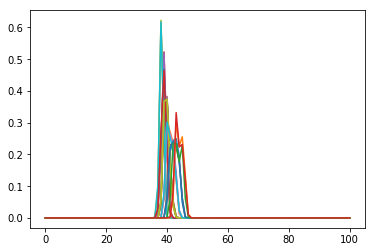

In [37]:
target, inp, mask, x_max = next(iter(dataset))

forecast = inp[:8,:]
blank    = tf.zeros_like(forecast[:,-1:])
forecast = tf.concat([forecast, blank], 1)
for n in range(120-12, 120-2):
    pred = model(forecast[:,-120:], train=False)
    pred = tf.log(tf.nn.softmax(pred[:,n]))
    pred = tf.random.multinomial(pred, 1) / hparams.quantization_channels
    #pred = tf.argmax(pred, -1) / (hparams.quantization_channels + 1)
    pred = tf.reshape(tf.cast(pred, tf.float32), [-1,1,1])
    forecast = tf.concat([forecast[:,:n+1], pred, forecast[:,n+2:]], 1)
    
for n in range(24):
    pred = model(forecast[:,-120:], train=False)
    pred = tf.log(tf.nn.softmax(pred[:,-1]))
    plt.plot(np.exp(pred[0]))

    pred = tf.random.multinomial(pred, 1) / hparams.quantization_channels
    #pred = tf.argmax(pred, -1) / (hparams.quantization_channels + 1)
    pred = tf.reshape(tf.cast(pred, tf.float32), [-1,1,1])
    forecast = tf.concat([forecast[:,:-1], pred, blank], 1)
    

plt.show()
    

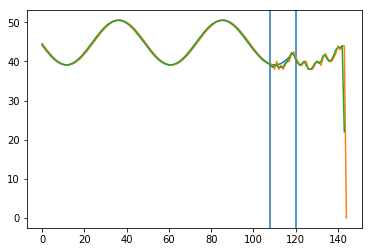

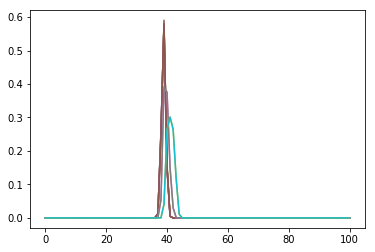

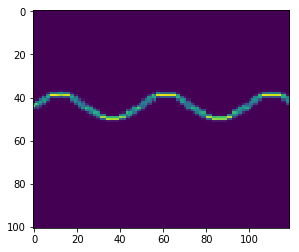

In [38]:
TARGET = 0
plt.plot(np.squeeze(inp[TARGET,:]) * hparams.quantization_channels)
plt.axvline(x=120-12)
plt.axvline(x=120)
#plt.plot(np.squeeze(np.concatenate([inp[0], inp[129]], axis=0)) * np.max(x_max))

plt.plot(np.squeeze(forecast[TARGET]).T * hparams.quantization_channels)
plt.plot(np.convolve(forecast[TARGET,:,0], [0.5, 0.5])[1:-1] * hparams.quantization_channels)
#plt.plot(np.convolve(forecast[3,:,0], [0.5, 0.5])[1:-1] * np.max(x_max))


plt.show()

pred = model(inp[:TARGET+2])
pred = tf.reshape(pred, [TARGET+2, 120-1, -1])
plt.plot(np.squeeze(tf.nn.softmax(pred[TARGET,-10:])).T)
plt.show()
plt.imshow(np.squeeze(tf.nn.softmax(pred))[TARGET].T)
plt.show()

## Save Model

In [36]:
import h5py
import time, datetime, os

def save_model(model, optimizer, dataset, hparams, name, stats=None, path='../outputs/'):
    """
    Method for saving model, parameters, hyperparameters and outputs
    """
    path += name + '_' + datetime.datetime.now().strftime('%y-%m-%d-%H_%M_%S') + '/'
    os.mkdir(path)

    # Save model and parameters
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
    checkpoint.save(file_prefix = path)

    # Save hyperparameters
    with open(path + 'hparams.json', 'w') as file:
        file.write(hparams.to_json())

    # Save predictions and actual data
    preds, acts, maxs = [], [], []
    for inp, target, mask, x_max in dataset:
        pred = model(inp, mask)
        preds.extend(np.array(pred))
        acts.extend(np.array(target))
        maxs.extend(np.array(x_max))

    with h5py.File(path + 'data.hdf5', 'w') as file:
        file.create_dataset('actual', data=np.array(acts))
        file.create_dataset('predicted', data=np.array(preds))
        file.create_dataset('x_max', data=np.array(x_max))
        if stats != None:
            for stat_name, stat in stats.items():
                file.create_dataset('stat_' + stat_name, data=np.array(stat))
                

save_model(model, optimizer, dataset, hparams, 'gpt-discrete-sin-test-random-period', stats=None, path='../outputs/')

## Test Hyperparameters

In [ ]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = WaveNet(params)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 3, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -3.5000 Loss 0.0254 Accuracy 0.0254 Time 32.2
Learning Rate -3.0000 Loss 0.0247 Accuracy 0.0247 Time 31.2
Learning Rate -2.5000 Loss 0.0254 Accuracy 0.0254 Time 31.5

## Test Model Accuracy

In [ ]:
model_accuracy = []

In [ ]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

https://openai.com/blog/better-language-models/

https://github.com/openai/finetune-transformer-lm